Data from [An integrated single-cell reference atlas of the human endometrium](https://doi.org/10.1038/s41588-024-01873-w)

In [1]:
import anndata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from CoPhaser import utils
from CoPhaser.trainer import Trainer
from CoPhaser.loss import Loss
from CoPhaser import plotting
from CoPhaser.model import CoPhaser
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DATA_FOLDER = "../../../data/"
adata = anndata.read_h5ad(
    f"{DATA_FOLDER}/menstrual_cycle/endometriumAtlasV2_nuclei.h5ad"
)

In [4]:
adata

AnnData object with n_obs × n_vars = 312246 × 33578
    obs: 'n_genes', 'sample', 'library', 'Processing', 'Treatment', '10x kit', 'percent_mito', 'n_counts', 'scrublet_score', 'genotype', 'Library_genotype', 'Group', 'discard_lowQC', 'Endometriosis_stage', 'Hormonal treatment', 'Age', 'Binary Stage', 'Stage', 'phase', 'dataset', 'Biopsy_type', 'Tissue_sampled', 'LT_celltype', 'LT_epi_celltype', 'LT_mesen_celltype', 'Endometrial_pathology', 'celltype', 'lineage', 'label_long'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'n_cells-15', 'gene_ids-16', 'feature_types-16', 'n_cells-16', 'gene_ids-17', 'feature_types-17', 'n_cells-17', 'gene_ids-18', 'feature_ty

In [13]:
adata.obs.celltype.value_counts()

celltype
eStromal                46062
SOX9_functionalis_II    38538
eStromal_MMPs           21598
preGlandular            18101
Immune_Lymphoid         16948
Cycling                 16859
dStromal_early          16576
Glandular               15355
Glandular_secretory     14854
dStromal_late           14310
Immune_Myeloid          13895
dStromal_mid            13676
eHormones               13459
eStromal_cycling         9922
MUC5B                    9246
SOX9_luminal             6006
HOXA13                   5133
SOX9_basalis             4708
preLuminal               3822
Venous                   3394
Luminal                  3146
Ciliated                 2606
ePV_2                    1488
Lymphatic                 621
preCiliated               590
SOX9_functionalis_I       577
ePV_1b                    349
Arterial                  151
ePV_1a                    122
Fibroblast_basalis         85
uSMCs                      49
Name: count, dtype: int64

In [14]:
adata_stromal = adata[adata.obs.celltype.apply(lambda c: "Stromal" in c)]

In [15]:
adata_stromal.layers["total"] = np.rint(
    (np.exp(adata_stromal.X.toarray()) - 1)
    * adata_stromal.obs["n_counts"].to_numpy().reshape(-1, 1)
    / 10000
)

/tmp/ipykernel_1290670/1088057246.py:1: ImplicitModificationWarning: Setting element `.layers['total']` of view, initializing view as actual.
  adata_stromal.layers["total"] = np.rint(


<Axes: xlabel='celltype', ylabel='count'>

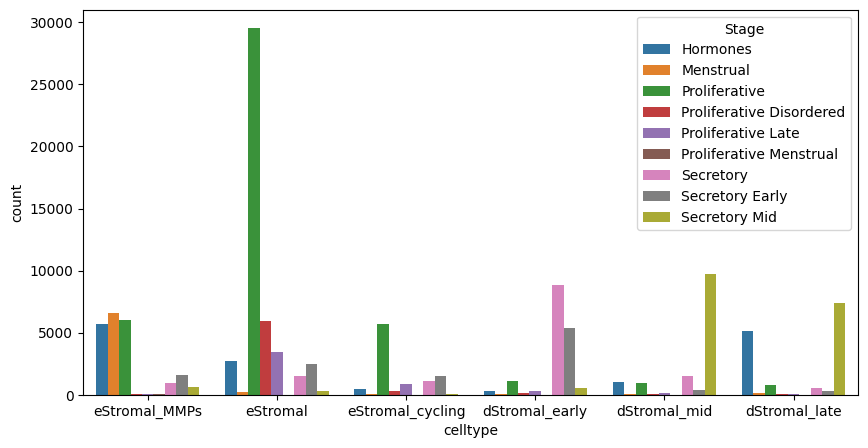

In [16]:
plt.subplots(figsize=(10, 5))
sns.countplot(adata_stromal.obs, x="celltype", hue="Stage")

<Axes: xlabel='total_counts', ylabel='Count'>

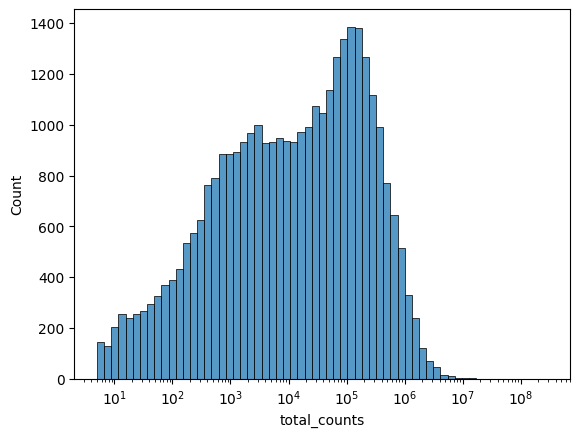

In [18]:
sns.histplot(x=adata_stromal.var["total_counts"], log_scale=True)

In [19]:
adata_stromal.obs.Stage.value_counts()

Stage
Proliferative               44056
Secretory Mid               18493
Hormones                    15285
Secretory                   14293
Secretory Early             11527
Menstrual                    7100
Proliferative Disordered     6544
Proliferative Late           4801
Proliferative Menstrual        45
Name: count, dtype: int64

In [22]:
adata_stromal_tot = adata_stromal.copy()

In [23]:
adata_stromal = adata_stromal[adata_stromal.obs.sample(frac=0.25).index].copy()

In [24]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from scipy.sparse import issparse


def compute_mutual_information(adata, obs_key="Stage", layer="total"):
    """
    Computes the mutual information between a discrete variable in `obs`
    and the normalized log1p expression of each gene in a given layer.

    Parameters:
    - adata: AnnData object
    - obs_key: str, key in `adata.obs` corresponding to a discrete variable
    - layer: str, key in `adata.layers` with raw count values

    Returns:
    - pandas.Series with gene names as index and mutual information scores as values
    """

    # Get the counts matrix
    X = adata.layers[layer]
    if issparse(X):
        X = X.toarray()

    # Normalize by total counts per cell
    total_counts = X.sum(axis=1, keepdims=True)
    X_norm = np.log1p(X / total_counts)

    # Get discrete labels
    y = adata.obs[obs_key].astype("category").cat.codes.values

    # Compute MI
    mi_scores = mutual_info_classif(X_norm, y, discrete_features=False, random_state=0)

    return pd.Series(mi_scores, index=adata.var_names, name="mutual_information")

In [25]:
var_genes = utils.get_variable_genes(adata_stromal, n_variable_genes=4000)

In [27]:
# mi_scores = compute_mutual_information(adata_stromal[:,var_genes], obs_key="Stage", layer="total")
# mi_scores.sort_values(ascending=False).head()

In [28]:
mi_scores = pd.read_csv("mi_fibroblast.csv", index_col=0)

In [29]:
cycling_genes = mi_scores[mi_scores["mutual_information"] > 0.1].index.values

In [30]:
len(cycling_genes)

93

In [35]:
g = utils.get_variable_genes(adata_stromal, 2000, "total")

Epoch 1/200, elbo_loss: 1083.7869, kl_div_f: 4.6815, kl_div_z: 29.3388, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -2.8921, entropy_loss: -289.2061, radial_variance: 5.4238, radius: 17.2157, L1_mu_z: 0.0000, MI_loss: 0.0000, total_loss: 817.2204
Epoch 2/200, elbo_loss: 979.5630, kl_div_f: 4.6289, kl_div_z: 30.1134, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.3718, entropy_loss: -337.1808, radial_variance: 2.7120, radius: 3.7931, L1_mu_z: 0.0000, MI_loss: 0.0147, total_loss: 650.3591
Epoch 3/200, elbo_loss: 956.2823, kl_div_f: 4.5669, kl_div_z: 32.1287, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.3876, entropy_loss: -338.7593, radial_variance: 2.2391, radius: 3.2133, L1_mu_z: 0.0000, MI_loss: 0.0703, total_loss: 630.0081
Epoch 4/200, elbo_loss: 957.6884, kl_div_f: 4.5019, kl_div_z: 37.9197, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.3895, entropy

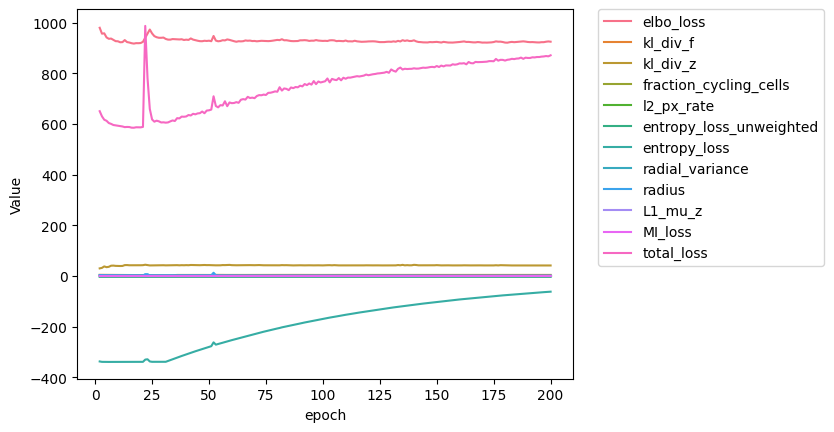

In [ ]:
model = CoPhaser(cycling_genes, g, n_latent=10, n_harm=3, use_mu_z_encoder=True)
model.load_anndata(adata_stromal, layer_to_use="total")
trainer = Trainer(
    model,
    Loss.compute_loss,
    noise_model="NB",
    L2_Z_decoder_loss_weight=0,
    entropy_weight_factor=100,
    MI_weight=100,
    closed_circle_weight=30,
    cycling_status_prior=1,
)
trainer.train_model(
    n_epochs=200,
    lr=1e-2,
    device="cuda",
    batch_size=1024,
)
# model.load_circular_decoder("../../pretrained_decoder/rhythmic_weight_3_harm.pt")

<Axes: ylabel='Count'>

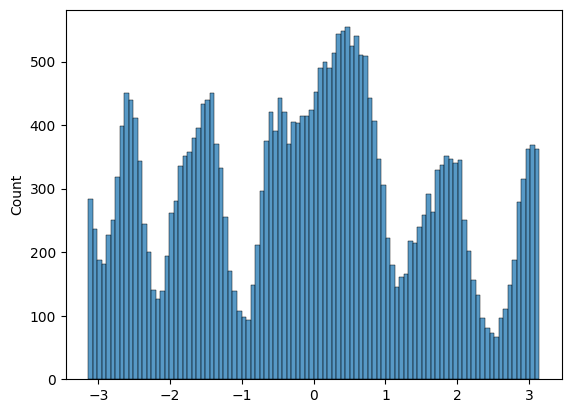

In [39]:
# Get the infered theta values
model.to("cpu")
generative_outputs, space_outputs = model.get_outputs()
thetas = space_outputs["theta"].detach().numpy()
sns.histplot(thetas, bins=100)

<Axes: ylabel='Density'>

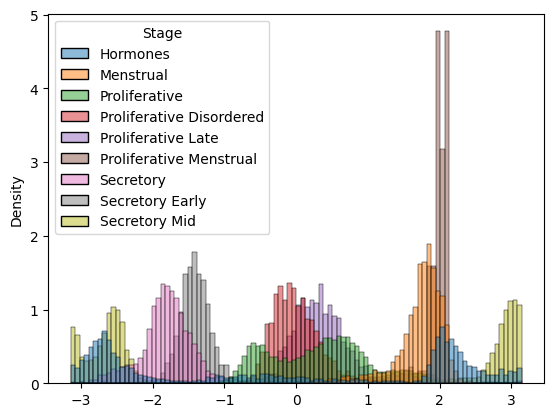

In [42]:
sns.histplot(
    x=thetas,
    bins=100,
    hue=adata_stromal.obs["Stage"],
    stat="density",
    common_norm=False,
)

In [44]:
thetas_tot = model.infer_pseudotimes(adata_stromal_tot, "total", False)
thetas_tot = thetas_tot.detach().numpy()

<Axes: ylabel='Density'>

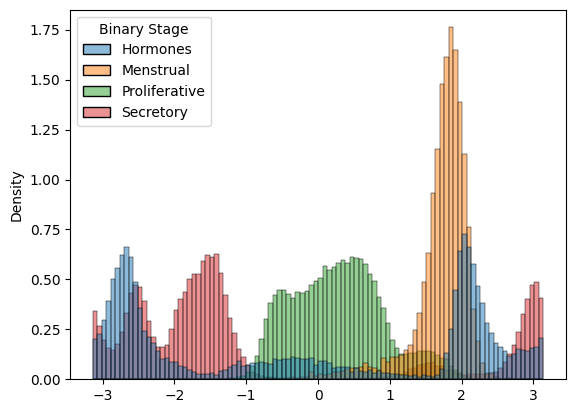

In [46]:
sns.histplot(
    x=thetas_tot,
    bins=100,
    hue=adata_stromal_tot.obs["Binary Stage"],
    stat="density",
    common_norm=False,
)

In [47]:
adata_stromal_tot.obs["inferred_theta"] = thetas_tot

In [48]:
adata_stromal_tot.obs["has_endometriosis"] = (
    adata_stromal_tot.obs["Endometriosis_stage"].astype(int) > 0
)

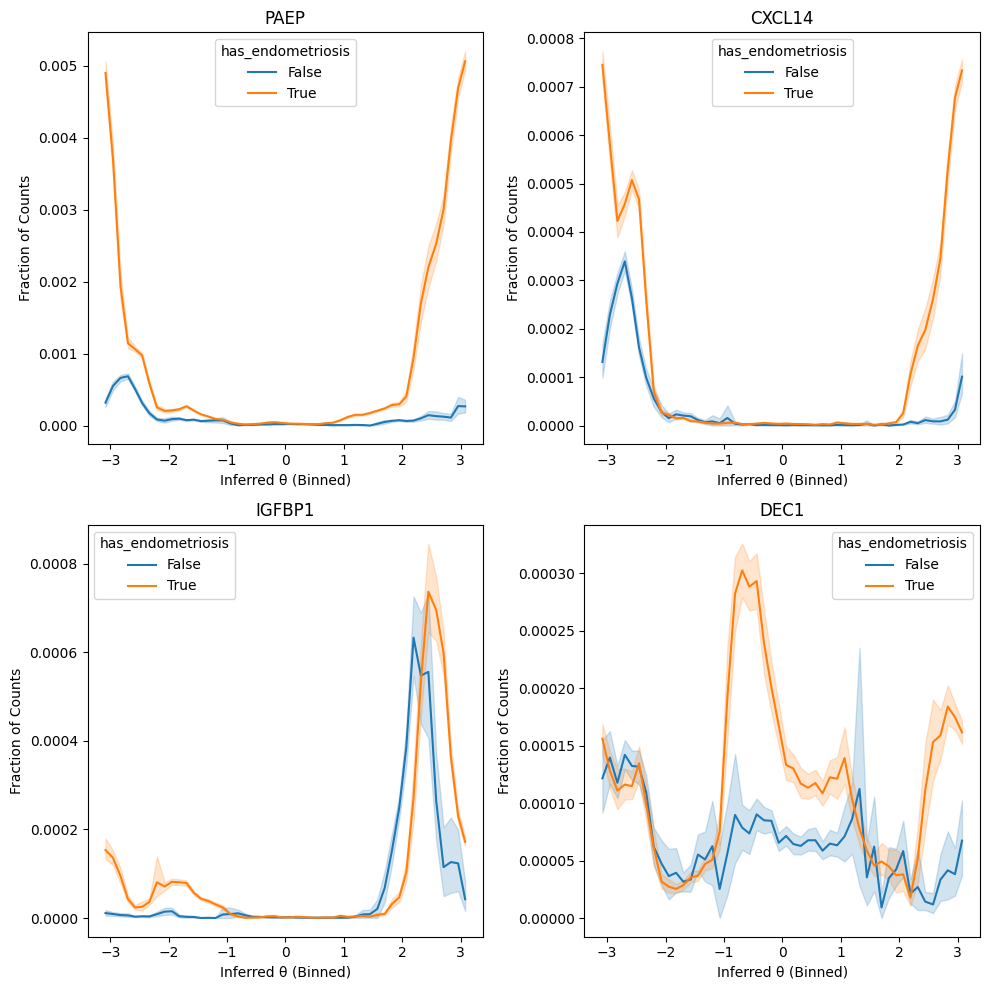

In [50]:
def plot_gene_profile(
    adata,
    genes=["PAEP", "CXCL14", "IGFBP1", "DEC1"],
    layer_to_use="total",
    ncols=2,
    gene_to_upper=False,
    library_size=None,
    cell_type_field="cell_type",
    n_bins=50,  # Number of bins for inferred θ
):
    # Determine grid size
    nrows = np.ceil(len(genes) / ncols).astype(int)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))
    axs = axs.flatten()

    # Convert gene names to uppercase if needed
    if gene_to_upper:
        genes = [gene.upper() for gene in genes]

    # Calculate library size if not provided
    if library_size is None:
        library_size = adata.layers[layer_to_use].sum(axis=1)

    # Extract inferred θ and batch information
    inferred_theta = adata.obs["inferred_theta"].values
    cell_type = adata.obs[cell_type_field].values

    for i, gene in enumerate(genes):
        if i >= len(axs):
            break  # Skip extra axes

        # Extract expression data for the gene
        expression = (
            adata[:, gene].layers[layer_to_use].toarray().flatten() / library_size
        )

        # Create a DataFrame for plotting
        df = pd.DataFrame(
            {
                "inferred_theta": inferred_theta,
                "expression": expression,
                cell_type_field: cell_type,
            }
        )

        # Bin inferred θ into `n_bins` bins
        df["theta_bin"] = pd.cut(df["inferred_theta"], bins=n_bins, labels=False)
        df["binned_theta"] = df.groupby("theta_bin")["inferred_theta"].transform("mean")

        # Compute the mean expression in each bin for each cell_type
        bin_means = (
            df.groupby(["theta_bin", cell_type_field])["expression"].mean().unstack()
        )

        # Calculate the ratio of cell_type means for each bin
        # avg_ratio = ((bin_means.iloc[:,1] - bin_means.iloc[:,0]) / (bin_means.iloc[:,1] + bin_means.iloc[:,0])).mean() * 100# Assuming cell_type labels are 0 and 1
        # print(f"Gene: {gene}, Average Ratio (cell_type 1 / cell_type 0): {avg_ratio:.3f}")

        # Plot smoothed gene profile using sns.lineplot
        sns.lineplot(
            data=df,
            x="binned_theta",
            y="expression",
            hue=cell_type_field,
            ax=axs[i],
        )

        # Set plot labels and title
        axs[i].set(
            xlabel="Inferred θ (Binned)",
            ylabel="Fraction of Counts",
            title=f"{gene}",
        )

    # Adjust layout
    plt.tight_layout()
    plt.show()


plot_gene_profile(
    adata_stromal_tot,
    layer_to_use="total",
    cell_type_field="has_endometriosis",
)

<Axes: xlabel='inferred_theta', ylabel='Count'>

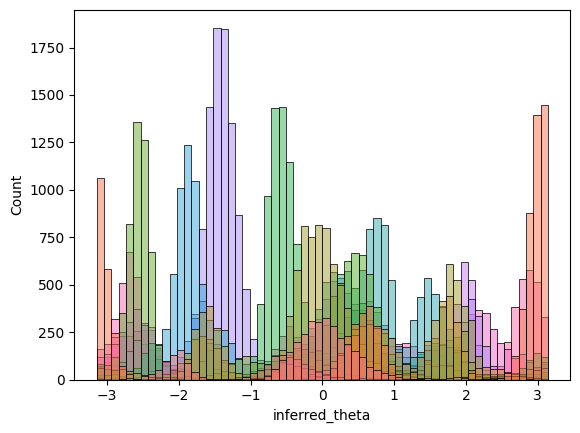

In [51]:
sns.histplot(
    adata_stromal_tot.obs,
    x="inferred_theta",
    hue="genotype",
    legend=False,
)

<Axes: xlabel='inferred_theta', ylabel='Density'>

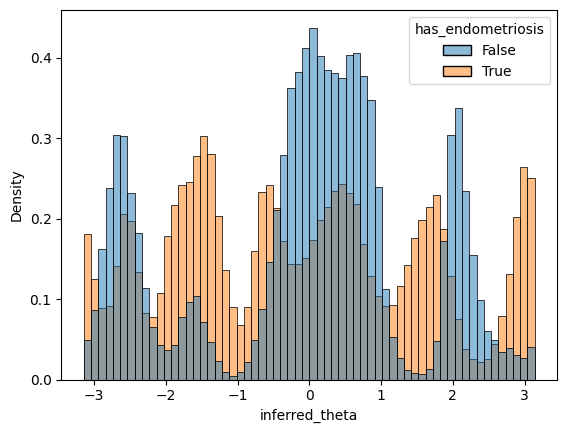

In [52]:
sns.histplot(
    adata_stromal_tot.obs,
    x="inferred_theta",
    hue="has_endometriosis",
    legend=True,
    stat="density",
    common_norm=False,
)

In [53]:
mu_z = generative_outputs["Z"].detach().numpy()

In [54]:
df_mu_z = pd.DataFrame(mu_z, columns=model.context_genes)

In [55]:
df_mu_z["has_endometriosis"] = (
    adata_stromal.obs["Endometriosis_stage"].astype(int) > 0
).values

In [56]:
mean_mu_z = df_mu_z.groupby(by="has_endometriosis").mean().T
mean_mu_z["diff"] = np.abs(mean_mu_z.loc[:, True] - mean_mu_z.loc[:, False])

In [57]:
mean_mu_z.sort_values(by="diff", ascending=False).head(40)

has_endometriosis,False,True,diff
AC104024.1,-2.193408,-1.682065,0.511343
AC004241.2,-3.411633,-2.976067,0.435565
BX322559.1,-3.557194,-3.131185,0.426009
AL359313.1,-1.253062,-1.645747,0.392685
AC009135.1,-2.518822,-2.135423,0.383399
CDC45,-1.561649,-1.198641,0.363008
AC124276.1,-2.161485,-2.522256,0.360771
AC114812.2,-1.197210,-0.841669,0.355541
IGLC3,-1.083346,-0.730437,0.352909
LINC-ROR,-1.198404,-0.846732,0.351672


<Axes: ylabel='Density'>

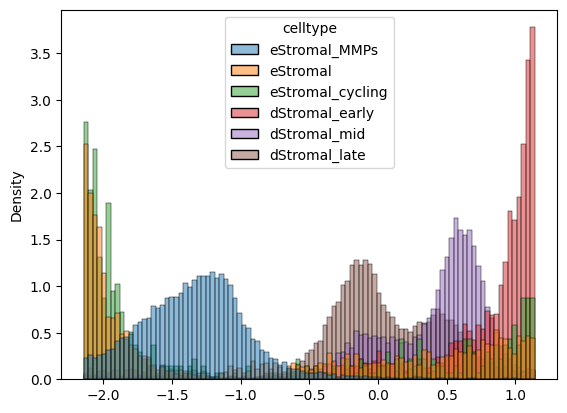

In [61]:
i = (thetas_tot > 1) | (thetas_tot < -2)
sns.histplot(
    x=utils.normalize_angles(thetas_tot[i] + np.pi),
    bins=100,
    hue=adata_stromal_tot.obs["celltype"][i],
    stat="density",
    common_norm=False,
)

/home/maxine/miniconda3/envs/VAE_Fourrier_Env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/maxine/miniconda3/envs/VAE_Fourrier_Env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Axes: >

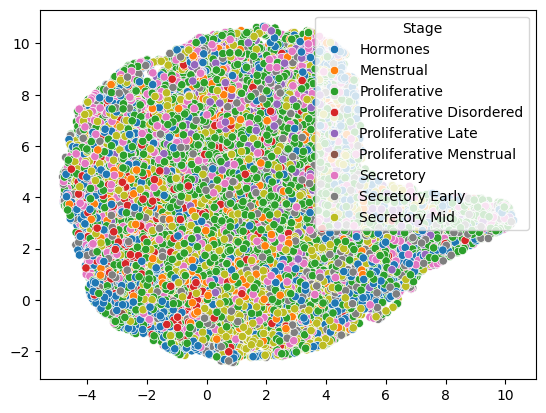

In [84]:
import umap

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(space_outputs["z"].detach().numpy())
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=adata_stromal.obs["Stage"])

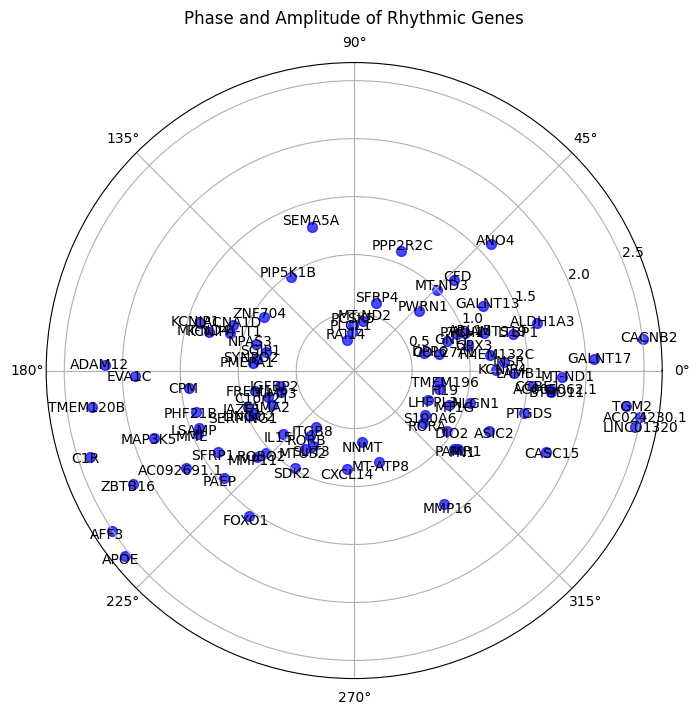

In [85]:
model.plot_fourier_coefficients()

In [ ]:
# to_save = {
#     "adata_stromal_tot": adata_stromal_tot,
#     "thetas_tot": thetas_tot,
#     "z_space": embedding,
#     "fourier_coefficients": model.rhythmic_decoder.fourier_coefficients.weight.detach().numpy(),
#     "small_obs": adata_stromal.obs,
#     "variable_genes": model.context_genes,
#     "seed_genes": cycling_genes,
# }
# import pickle

# with open("data/menstrual_cycle_results.pkl", "wb") as f:
#     pickle.dump(to_save, f)

In [87]:
adata.obs.columns

Index(['n_genes', 'sample', 'library', 'Processing', 'Treatment', '10x kit',
       'percent_mito', 'n_counts', 'scrublet_score', 'genotype',
       'Library_genotype', 'Group', 'discard_lowQC', 'Endometriosis_stage',
       'Hormonal treatment', 'Age', 'Binary Stage', 'Stage', 'phase',
       'dataset', 'Biopsy_type', 'Tissue_sampled', 'LT_celltype',
       'LT_epi_celltype', 'LT_mesen_celltype', 'Endometrial_pathology',
       'celltype', 'lineage', 'label_long'],
      dtype='object')

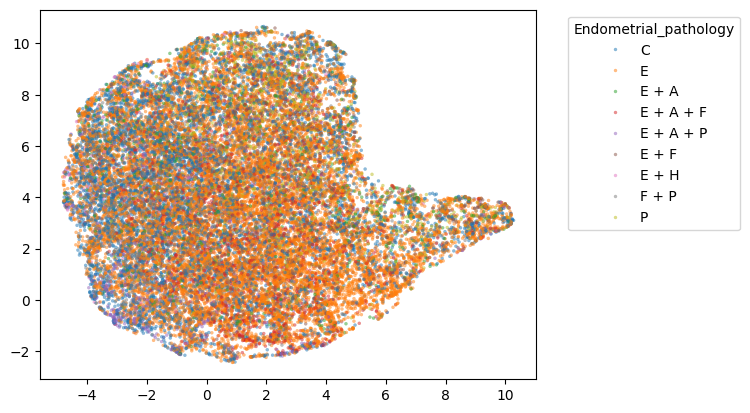

In [89]:
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=adata_stromal.obs["Endometrial_pathology"],
    alpha=0.5,
    edgecolor=None,
    s=5,
)
sns.move_legend(
    ax,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)